# Problem sugestion with MAB algorithms

We are using a simple MAB algorithm to select problems to competitive programming competitors. In this work we first introduce the base case.

First we start with the Epsilon-Greedy algorithm.

## The data

The algorithm will be trainning using the data from the URI Onlide Judge. We solve around of 200k solutions.
The solutions is a list of tuples composed by `(problem_id, user_id, date)`.

At first we will read the data and sort by date.

In [291]:
import random, math
from itertools import groupby
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt

In [292]:
solutions_df = pd.read_csv('fake_solutions.csv')
solutions_df[:5]

,user,problem,category,date
0,0,1001,1,0
1,0,1002,1,1
2,0,1003,1,2
3,0,1004,1,3
4,0,1005,1,4


And we will filter the problem by category.

In [293]:
#solutions_df = solutions_df.loc[solutions_df['category'] == 1]
#solutions_df[:5]

So, we need to sort the solutions by date:

In [294]:
solutions_df = solutions_df.sort_values(['user', 'date'])
solutions_df[:5]

,user,problem,category,date
0,0,1001,1,0
1,0,1002,1,1
2,0,1003,1,2
3,0,1004,1,3
4,0,1005,1,4


Now, we will get the set of problems and users.

In [295]:
problems = solutions_df['problem']
problems = set(problems)
problems = list(problems)
len(problems)
problems[:5]

[1001, 1002, 1003, 1004, 1005]

In [296]:
users = solutions_df['user']
users = set(users)
users = list(users)
users[:5]

[0, 1, 2, 3, 4]

Now, we will split the data in trainning and testing. What we will do, is select some users to be part of the trainning set and then all theirs solutions will be part of the trainning dataset.

In [297]:
random.seed(0)
random.shuffle(users)

num_trainning_users = int((len(users) * 0.4))

trainning_users = users[:num_trainning_users]
testing_users = users[num_trainning_users:]

trainning_users[:5]

[65, 175, 377, 587, 733]

Now, we can split the data. 
OBS: The problems are indexed py your id. How they are sequential, we will decrease the value 1001 of each one. Because this will make the code more simple.

In [298]:
Solution = namedtuple('Solution', 'problem, user')
trainning_solutions = []
testing_solutions = []

for row in solutions_df.itertuples():
    if row.user in testing_users:
        testing_solutions.append(
            Solution(row.problem - 1001, row.user)
        )
    else:
        trainning_solutions.append(
            Solution(row.problem - 1001, row.user)
        )
        
trainning_solutions[:5]

[Solution(problem=0, user=2),
 Solution(problem=1, user=2),
 Solution(problem=2, user=2),
 Solution(problem=3, user=2),
 Solution(problem=4, user=2)]

At this point we have everything that is necessary to test our algorithms. To start, we will use the Epsilon-Greedy algorithm

In [299]:
class EpsilonGreedy():
    def __init__(self, n_arms):
        self.epsilon = 0.1
        self.n_arms = n_arms
        self.counts = [0     for col in range(n_arms)]
        self.values = [0.0   for col in range(n_arms)]
        self.chosen = [False for col in range(n_arms)]


    def initialize(self):
        self.chosen = [False for col in range(self.n_arms)]


    def max_arm(self):
        max_arm = 0
        max_value = -1
        
        for arm in range(self.n_arms):
            if self.chosen[arm]:
                continue
            if self.values[arm] > max_value:
                max_arm = arm
                max_value = self.values[arm]

        return max_arm

    
    def rand_arm(self):
        rand_arm = random.randrange(self.n_arms)
        
        while self.chosen[rand_arm]:
            rand_arm = random.randrange(self.n_arms)

        return rand_arm


    def select_arm(self):
        if random.random() > self.epsilon:
            return self.max_arm()
        else:
            return self.rand_arm()
  

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        self.chosen[chosen_arm] = True

        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

In [300]:
def categorical_draw(probs):
    z = random.random()
    cum_prob = 0.0
    for i in range(len(probs)):
        prob = probs[i]
        cum_prob += prob
        if cum_prob > z:
            return i
    
    return len(probs) - 1

class Softmax:
    def __init__(self, n_arms):
        self.temperature = 0.1
        self.n_arms = n_arms
        self.counts = [0     for col in range(n_arms)]
        self.values = [0.0   for col in range(n_arms)]
        self.chosen = [False for col in range(n_arms)]

    def initialize(self):
        self.chosen = [False for col in range(self.n_arms)]
  
    def select_arm(self):
        z = sum([math.exp(v / self.temperature) for v in self.values])
        probs = [math.exp(v / self.temperature) / z for v in self.values]
        return categorical_draw(probs)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value


And we have a test structure

In [301]:
def test_algorithm(algo, solutions):
    n_solutions      = len(solutions)
    rewards            = [0 for i in range(n_solutions)]
    cumulative_rewards = [0 for i in range(n_solutions)]
    chosen_arms        = [0 for i in range(n_solutions)]
    
    algo.initialize()
  
    for i, solution in enumerate(solutions):
        chosen_arm = algo.select_arm()
        chosen_arms[i] = chosen_arm

        if chosen_arm == solution:
            reward = 1
        else:
            reward = 0
        
        rewards[i] = reward
        cumulative_rewards[i] = cumulative_rewards[i - 1] + reward
        algo.update(chosen_arm, reward)
        algo.chosen[solution] = True

    return sum(rewards) / float(n_solutions)

So, for each user in the dataset, we will use the algorithm. And then plot the result of the accuracy of the algorithm.

In [302]:
algo = EpsilonGreedy(max(problems))
total_rewards = []

for user, solutions in groupby(trainning_solutions, lambda x: x.user):
    solutions = [s.problem for s in solutions]
    
    total_rewards.append(
        test_algorithm(algo, solutions)
    )

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0]
[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6666666666666666]
[0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6000000000000001]
[0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 0.5000000000000001]
[0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 0.42857142857142866]
[0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.4, 0.37500000000000006]
[0.0, 0.3333333333333333, 0.3

[0.0, 0.23529411764705882, 0.18181818181818185, 0.2, 0.1891891891891892, 0.21212121212121213, 0.175, 0.18604651162790692, 0.1818181818181818, 0.18367346938775508]
[0.0, 0.2222222222222222, 0.18181818181818185, 0.25, 0.2105263157894737, 0.2058823529411765, 0.175, 0.18181818181818177, 0.21739130434782608, 0.17999999999999997]
[0.0, 0.2631578947368421, 0.18181818181818185, 0.23529411764705882, 0.23076923076923078, 0.2285714285714286, 0.175, 0.17777777777777773, 0.20833333333333334, 0.17647058823529407]
[0.0, 0.3, 0.18181818181818185, 0.2222222222222222, 0.25, 0.2285714285714286, 0.175, 0.17777777777777773, 0.2, 0.19230769230769224]
[0.0, 0.2857142857142857, 0.18181818181818185, 0.2631578947368421, 0.24390243902439024, 0.22222222222222224, 0.175, 0.19565217391304346, 0.19230769230769232, 0.1886792452830188]
[0.0, 0.2727272727272727, 0.18181818181818185, 0.24999999999999997, 0.23809523809523808, 0.21621621621621626, 0.175, 0.19148936170212763, 0.18518518518518517, 0.18518518518518512]
[0.0,

[0.0, 0.20967741935483863, 0.1875, 0.20689655172413784, 0.19277108433734935, 0.18666666666666662, 0.19298245614035078, 0.18604651162790692, 0.1791044776119402, 0.1702127659574468]
[0.0, 0.20634920634920625, 0.1875, 0.2033898305084745, 0.19047619047619044, 0.1842105263157894, 0.189655172413793, 0.18390804597701144, 0.17647058823529405, 0.16842105263157894]
[0.0, 0.20312499999999992, 0.1875, 0.19999999999999993, 0.18823529411764703, 0.18181818181818174, 0.18644067796610161, 0.18181818181818177, 0.1739130434782608, 0.16666666666666666]
[0.0, 0.19999999999999993, 0.1875, 0.19672131147540975, 0.18604651162790695, 0.19230769230769224, 0.18333333333333324, 0.17977528089887634, 0.17142857142857137, 0.16494845360824742]
[0.0, 0.1969696969696969, 0.1875, 0.1935483870967741, 0.18390804597701146, 0.18987341772151892, 0.19672131147540972, 0.18888888888888883, 0.18309859154929573, 0.17346938775510204]
[0.0, 0.19402985074626858, 0.1875, 0.19047619047619038, 0.18390804597701146, 0.18749999999999994, 0

[0.0, 0.24074074074074076, 0.23076923076923067, 0.22330097087378642, 0.2018348623853211, 0.20833333333333337, 0.19999999999999993, 0.2045454545454546, 0.19791666666666669, 0.1942446043165468]
[0.0, 0.23853211009174316, 0.24528301886792442, 0.23076923076923078, 0.2018348623853211, 0.20661157024793392, 0.20792079207920786, 0.20300751879699253, 0.19587628865979384, 0.1928571428571429]
[0.0, 0.2454545454545455, 0.24074074074074064, 0.2285714285714286, 0.2018348623853211, 0.20491803278688528, 0.2058823529411764, 0.20149253731343286, 0.19387755102040818, 0.1914893617021277]
[0.0, 0.24324324324324328, 0.23636363636363628, 0.2285714285714286, 0.2018348623853211, 0.21138211382113822, 0.203883495145631, 0.2, 0.19191919191919196, 0.19014084507042256]
[0.0, 0.24107142857142863, 0.23214285714285704, 0.22641509433962267, 0.2018348623853211, 0.20967741935483872, 0.20192307692307687, 0.1985294117647059, 0.19000000000000003, 0.19580419580419584]
[0.0, 0.2389380530973452, 0.22807017543859637, 0.22429906

[0.0, 0.2229729729729731, 0.2222222222222222, 0.2222222222222223, 0.22068965517241385, 0.21518987341772156, 0.20863309352517984, 0.21084337349397603, 0.20437956204379573, 0.20441988950276244]
[0.0, 0.22147651006711425, 0.23076923076923075, 0.22068965517241387, 0.21917808219178087, 0.21383647798742142, 0.20863309352517984, 0.20958083832335342, 0.21014492753623198, 0.2032967032967033]
[0.0, 0.2266666666666668, 0.22826086956521738, 0.2191780821917809, 0.21768707482993202, 0.21250000000000005, 0.20863309352517984, 0.2142857142857144, 0.20863309352517997, 0.20218579234972678]
[0.0, 0.2317880794701988, 0.22580645161290322, 0.21768707482993205, 0.21621621621621626, 0.21739130434782614, 0.20863309352517984, 0.21301775147929006, 0.20714285714285727, 0.20218579234972678]
[0.0, 0.23026315789473698, 0.22340425531914893, 0.21621621621621628, 0.22147651006711414, 0.21604938271604943, 0.21428571428571427, 0.21176470588235305, 0.20567375886524836, 0.20218579234972678]
[0.0, 0.22875816993464065, 0.2210

[0.0, 0.23157894736842116, 0.23015873015873023, 0.2295081967213115, 0.22872340425531915, 0.22872340425531906, 0.22598870056497172, 0.22222222222222232, 0.21787709497206711, 0.2169811320754717]
[0.0, 0.230366492146597, 0.22834645669291345, 0.2282608695652174, 0.2275132275132275, 0.22751322751322742, 0.22471910112359547, 0.22115384615384626, 0.21666666666666676, 0.215962441314554]
[0.0, 0.2291666666666668, 0.22656250000000006, 0.22702702702702707, 0.2263157894736842, 0.2263157894736841, 0.22346368715083795, 0.2200956937799044, 0.22099447513812165, 0.2196261682242991]
[0.0, 0.22797927461139908, 0.23255813953488375, 0.22580645161290328, 0.225130890052356, 0.22513089005235593, 0.22222222222222218, 0.22380952380952393, 0.2197802197802199, 0.22325581395348842]
[0.0, 0.23195876288659806, 0.2307692307692308, 0.22459893048128346, 0.225130890052356, 0.22916666666666657, 0.22222222222222218, 0.22274881516587688, 0.2197802197802199, 0.22222222222222227]
[0.0, 0.2307692307692309, 0.2290076335877863,

[0.0, 0.22666666666666682, 0.22500000000000003, 0.22171945701357468, 0.22072072072072071, 0.21834061135371166, 0.21658986175115214, 0.2131147540983608, 0.21818181818181823, 0.215686274509804]
[0.0, 0.22566371681415945, 0.22360248447204972, 0.22072072072072074, 0.21973094170403587, 0.21739130434782597, 0.22018348623853218, 0.2131147540983608, 0.21719457013574667, 0.21484375000000006]
[0.0, 0.2246696035242292, 0.22222222222222224, 0.2197309417040359, 0.22321428571428573, 0.22077922077922066, 0.21917808219178087, 0.2131147540983608, 0.21621621621621628, 0.21400778210116736]
[0.0, 0.22368421052631593, 0.22699386503067487, 0.2197309417040359, 0.22222222222222224, 0.21982758620689644, 0.21818181818181823, 0.2131147540983608, 0.21524663677130051, 0.21317829457364346]
[0.0, 0.2270742358078604, 0.225609756097561, 0.2197309417040359, 0.22123893805309736, 0.21888412017167372, 0.21719457013574667, 0.2131147540983608, 0.21428571428571436, 0.2123552123552124]
[0.0, 0.2304347826086958, 0.230303030303

[0.0, 0.22846441947565557, 0.23232323232323235, 0.22779922779922787, 0.22605363984674343, 0.22348484848484843, 0.22007722007722022, 0.21739130434782622, 0.21653543307086623, 0.21959459459459463]
[0.0, 0.23134328358208972, 0.2311557788944724, 0.226923076923077, 0.22519083969465664, 0.2264150943396226, 0.22307692307692323, 0.21739130434782622, 0.219607843137255, 0.21885521885521889]
[0.0, 0.23048327137546484, 0.23000000000000004, 0.22605363984674337, 0.2281368821292777, 0.22556390977443602, 0.22605363984674345, 0.21739130434782622, 0.2187500000000001, 0.21812080536912754]
[0.0, 0.2296296296296298, 0.22885572139303487, 0.22605363984674337, 0.22727272727272743, 0.22471910112359544, 0.22519083969465667, 0.21739130434782622, 0.21789883268482502, 0.2173913043478261]
[0.0, 0.2287822878228784, 0.22772277227722776, 0.22900763358778636, 0.2264150943396228, 0.22761194029850743, 0.22433460076045644, 0.22021660649819505, 0.21705426356589158, 0.2166666666666667]
[0.0, 0.2316176470588237, 0.2315270935

[0.0, 0.23452768729641704, 0.23430962343096243, 0.23129251700680273, 0.23026315789473692, 0.22875816993464052, 0.2284768211920531, 0.22539682539682554, 0.22372881355932212, 0.22089552238805976]
[0.0, 0.23376623376623387, 0.23333333333333342, 0.23050847457627122, 0.22950819672131156, 0.2280130293159609, 0.22772277227722781, 0.2246835443037976, 0.22297297297297305, 0.2202380952380953]
[0.0, 0.2330097087378642, 0.23236514522821586, 0.22972972972972974, 0.22875816993464063, 0.22727272727272727, 0.2269736842105264, 0.2239747634069402, 0.22222222222222232, 0.22255192878338284]
[0.0, 0.23225806451612915, 0.23140495867768604, 0.22895622895622897, 0.228013029315961, 0.22653721682847897, 0.22950819672131156, 0.2239747634069402, 0.22222222222222232, 0.2218934911242604]
[0.0, 0.23151125401929273, 0.23045267489711943, 0.23154362416107382, 0.23051948051948062, 0.22903225806451616, 0.22875816993464063, 0.22327044025157247, 0.2214765100671142, 0.22123893805309738]
[0.0, 0.2339743589743591, 0.230452674

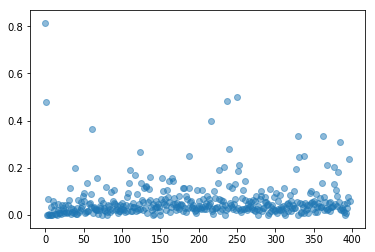

In [303]:
x = range(len(total_rewards))
y = total_rewards
plt.scatter(x, y, alpha=0.5)
plt.show()

In [304]:
total_rewards = []

for user, solutions in groupby(testing_solutions, lambda x: x.user):
    solutions = [s.problem for s in solutions]
    
    total_rewards.append(
        test_algorithm(algo, solutions)
    )

[0.0, 0.23652694610778457, 0.2348484848484849, 0.23343848580441648, 0.22935779816513766, 0.22891566265060243, 0.22699386503067498, 0.22781065088757405, 0.22784810126582294, 0.22500000000000003]
[0.0, 0.2358208955223882, 0.23396226415094343, 0.23270440251572336, 0.2286585365853659, 0.22822822822822825, 0.22699386503067498, 0.23008849557522132, 0.22712933753943235, 0.2243767313019391]
[0.0, 0.23809523809523822, 0.2368421052631579, 0.23510971786833862, 0.2286585365853659, 0.23053892215568864, 0.22699386503067498, 0.22941176470588243, 0.2264150943396228, 0.2237569060773481]
[0.0, 0.24035608308605352, 0.23970037453183524, 0.23750000000000004, 0.2286585365853659, 0.22985074626865673, 0.22935779816513774, 0.2287390029325514, 0.2257053291536052, 0.22314049586776863]
[0.0, 0.2396449704142013, 0.23880597014925378, 0.23676012461059195, 0.2286585365853659, 0.22916666666666669, 0.22865853658536597, 0.22807017543859656, 0.22500000000000017, 0.22252747252747257]
[0.0, 0.23893805309734523, 0.237918215

[0.0, 0.2446808510638299, 0.24104234527687293, 0.24166666666666675, 0.24119241192411917, 0.23626373626373623, 0.2333333333333334, 0.2289473684210527, 0.2299168975069253, 0.22727272727272732]
[0.0, 0.24403183023872688, 0.24104234527687293, 0.2409972299168976, 0.24054054054054047, 0.23561643835616436, 0.23268698060941834, 0.22834645669291348, 0.22928176795580119, 0.2267002518891688]
[0.0, 0.24338624338624346, 0.24025974025974023, 0.24033149171270726, 0.24258760107816701, 0.23770491803278687, 0.23480662983425418, 0.22834645669291348, 0.2286501377410469, 0.22613065326633172]
[0.0, 0.24274406332453832, 0.24025974025974023, 0.23966942148760337, 0.24193548387096764, 0.23705722070844684, 0.2341597796143251, 0.22774869109947654, 0.22802197802197807, 0.22556390977443613]
[0.0, 0.2421052631578948, 0.24025974025974023, 0.24175824175824182, 0.24128686327077736, 0.23641304347826086, 0.23626373626373628, 0.22774869109947654, 0.22739726027397267, 0.22500000000000006]
[0.0, 0.24146981627296596, 0.24025

[0.0, 0.24384236453201974, 0.2419825072886297, 0.23940149625935173, 0.2408759124087591, 0.23940149625935164, 0.23762376237623767, 0.22738386308068465, 0.22556390977443608, 0.22453703703703717]
[0.0, 0.24324324324324328, 0.24127906976744182, 0.24129353233830855, 0.2402912621359223, 0.23880597014925375, 0.2370370370370371, 0.22682926829268296, 0.225, 0.2240184757505775]
[0.0, 0.24264705882352947, 0.2434782608695652, 0.24069478908188593, 0.23970944309927358, 0.2382133995037221, 0.2364532019704434, 0.22627737226277375, 0.22443890274314215, 0.22350230414746558]
[0.0, 0.24449877750611254, 0.2427745664739884, 0.24009900990099017, 0.23913043478260868, 0.23762376237623764, 0.23832923832923839, 0.22815533980582528, 0.2263681592039801, 0.22528735632183922]
[0.0, 0.24634146341463423, 0.2449567723342939, 0.2419753086419754, 0.24096385542168672, 0.23762376237623764, 0.23774509803921576, 0.2276029055690073, 0.22580645161290322, 0.22477064220183499]
[0.0, 0.245742092457421, 0.24425287356321831, 0.2413

[0.0, 0.24999999999999994, 0.24806201550387588, 0.2460496613995486, 0.24379232505643336, 0.2415349887133184, 0.2410714285714287, 0.2428256070640177, 0.23488372093023258, 0.2330508474576272]
[0.0, 0.25167037861915365, 0.24999999999999992, 0.24774774774774783, 0.24549549549549546, 0.2415349887133184, 0.24276169265033418, 0.24229074889867847, 0.234338747099768, 0.2325581395348838]
[0.0, 0.25111111111111106, 0.249357326478149, 0.24719101123595513, 0.24494382022471906, 0.2415349887133184, 0.2422222222222223, 0.24175824175824182, 0.23379629629629634, 0.2320675105485233]
[0.0, 0.2505543237250554, 0.24871794871794864, 0.24887892376681622, 0.2466367713004484, 0.2415349887133184, 0.2416851441241686, 0.24122807017543865, 0.2355658198614319, 0.23368421052631588]
[0.0, 0.24999999999999994, 0.25063938618925824, 0.24832214765100677, 0.24608501118568227, 0.24324324324324337, 0.2411504424778762, 0.2407002188183808, 0.2373271889400922, 0.2352941176470589]
[0.0, 0.24999999999999994, 0.24999999999999994, 

[0.0, 0.25102880658436205, 0.2494172494172494, 0.24844720496894415, 0.24637681159420294, 0.24634655532359098, 0.24439918533604899, 0.24493927125506074, 0.24358974358974353, 0.24171539961013652]
[0.0, 0.2505133470225872, 0.2511627906976744, 0.25000000000000006, 0.24637681159420294, 0.24791666666666684, 0.24439918533604899, 0.24444444444444444, 0.24307036247334748, 0.2412451361867705]
[0.0, 0.25204918032786877, 0.2505800464037123, 0.24948453608247428, 0.24793388429752067, 0.24740124740124758, 0.2459349593495936, 0.24395161290322578, 0.24255319148936166, 0.24077669902912627]
[0.0, 0.2515337423312883, 0.25, 0.2489711934156379, 0.24742268041237114, 0.24688796680497943, 0.24543610547667355, 0.24346076458752514, 0.24203821656050953, 0.2403100775193799]
[0.0, 0.25102040816326526, 0.24942263279445728, 0.24845995893223824, 0.24897119341563784, 0.2484472049689443, 0.24696356275303655, 0.24497991967871482, 0.24364406779661013, 0.24177949709864607]
[0.0, 0.25050916496945, 0.2488479262672811, 0.2484

[0.0, 0.2495274102079394, 0.24838012958963282, 0.2471264367816091, 0.2461832061068701, 0.24414062500000017, 0.24577861163227022, 0.24394785847299807, 0.24356435643564353, 0.24236983842010779]
[0.0, 0.2490566037735848, 0.24784482758620688, 0.24665391969407255, 0.2457142857142856, 0.24414062500000017, 0.24531835205992514, 0.2434944237918215, 0.24308300395256913, 0.2419354838709678]
[0.0, 0.2485875706214688, 0.24731182795698922, 0.24618320610687014, 0.2452471482889733, 0.24414062500000017, 0.2448598130841122, 0.24304267161410012, 0.24260355029585795, 0.2432915921288015]
[0.0, 0.2499999999999999, 0.2489270386266094, 0.24761904761904754, 0.24667931688804542, 0.24414062500000017, 0.2444029850746269, 0.24444444444444438, 0.24409448818897633, 0.24285714285714294]
[0.0, 0.2495309568480299, 0.2483940042826552, 0.24714828897338398, 0.24621212121212108, 0.24414062500000017, 0.2458100558659218, 0.24399260628465796, 0.243614931237721, 0.2424242424242425]
[0.0, 0.2490636704119849, 0.24786324786324782

[0.0, 0.24868651488616444, 0.24646464646464644, 0.24733096085409242, 0.2455516014234874, 0.24680073126142602, 0.2452173913043479, 0.2439446366782006, 0.24131627056672747, 0.24114671163575066]
[0.0, 0.24825174825174806, 0.24646464646464644, 0.24689165186500878, 0.2451154529307281, 0.2463503649635037, 0.2447916666666667, 0.2435233160621761, 0.240875912408759, 0.24074074074074098]
[0.0, 0.24781849912739948, 0.2479838709677419, 0.24645390070921977, 0.24645390070921971, 0.24590163934426235, 0.24436741767764303, 0.243103448275862, 0.2404371584699452, 0.24033613445378174]
[0.0, 0.24781849912739948, 0.24748490945674043, 0.24601769911504417, 0.24601769911504412, 0.2454545454545455, 0.24394463667820074, 0.24268502581755588, 0.24181818181818168, 0.24161073825503376]
[0.0, 0.24912891986062702, 0.24899598393574296, 0.2473498233215547, 0.24734982332155464, 0.24682395644283128, 0.24525043177892925, 0.24398625429553258, 0.24319419237749534, 0.24288107202680084]
[0.0, 0.24912891986062702, 0.24899598393

[0.0, 0.2479474548440066, 0.2467289719626167, 0.2475083056478405, 0.2462809917355371, 0.2436115843270869, 0.24350649350649364, 0.24311183144246354, 0.24273504273504268, 0.2412698412698414]
[0.0, 0.2475409836065574, 0.24813432835820884, 0.24709784411276944, 0.2458745874587458, 0.24319727891156467, 0.24311183144246368, 0.24271844660194175, 0.24232081911262793, 0.2412698412698414]
[0.0, 0.24877250409165305, 0.24767225325884532, 0.2466887417218543, 0.24546952224052712, 0.24278438030560276, 0.2427184466019419, 0.24232633279483037, 0.24361158432708682, 0.2412698412698414]
[0.0, 0.25000000000000006, 0.2490706319702601, 0.24793388429752067, 0.24671052631578938, 0.24278438030560276, 0.2439418416801294, 0.2435483870967742, 0.2431972789115646, 0.2412698412698414]
[0.0, 0.24959216965742256, 0.2486085343228199, 0.24752475247524755, 0.24630541871921172, 0.24278438030560276, 0.24354838709677434, 0.2431561996779388, 0.24278438030560268, 0.24088748019017447]
[0.0, 0.24918566775244305, 0.248148148148148

[0.0, 0.24726134585289514, 0.2460732984293192, 0.245696400625978, 0.24458204334365308, 0.2443729903536978, 0.24390243902439035, 0.24349157733537521, 0.24198717948717952, 0.24287856071964026]
[0.0, 0.24687499999999998, 0.2456445993031357, 0.2453124999999999, 0.2442040185471405, 0.2439807383627609, 0.24353120243531212, 0.2431192660550459, 0.2432, 0.24251497005988032]
[0.0, 0.24648985959438377, 0.24521739130434764, 0.2449297971918876, 0.243827160493827, 0.24358974358974367, 0.2431610942249241, 0.24427480916030542, 0.2428115015974441, 0.2436472346786249]
[0.0, 0.24610591900311526, 0.24479166666666646, 0.2461059190031152, 0.243827160493827, 0.24358974358974367, 0.24430955993930206, 0.24390243902439032, 0.24242424242424243, 0.24328358208955234]
[0.0, 0.24572317262830481, 0.24610051993067572, 0.24572317262830476, 0.243827160493827, 0.24358974358974367, 0.24393939393939404, 0.2435312024353121, 0.24203821656050956, 0.2429210134128168]
[0.0, 0.2468944099378882, 0.24567474048442886, 0.24534161490

[0.0, 0.25037037037037047, 0.24999999999999994, 0.2485294117647059, 0.24401197604790403, 0.2450832072617248, 0.24463519313304727, 0.24351585014409222, 0.2424242424242425, 0.2415254237288137]
[0.0, 0.2500000000000001, 0.25123152709359603, 0.249632892804699, 0.24401197604790403, 0.24471299093655602, 0.24571428571428575, 0.2446043165467626, 0.2424242424242425, 0.24259520451339928]
[0.0, 0.2500000000000001, 0.25081967213114753, 0.249266862170088, 0.24401197604790403, 0.24434389140271506, 0.24536376604850216, 0.2442528735632184, 0.24205748865355528, 0.24225352112676068]
[0.0, 0.2500000000000001, 0.25040916530278234, 0.24890190336749637, 0.24401197604790403, 0.24397590361445795, 0.245014245014245, 0.24390243902439024, 0.24320241691842903, 0.24191279887482434]
[0.0, 0.2500000000000001, 0.25, 0.24853801169590645, 0.24514200298953648, 0.24511278195488734, 0.2446657183499289, 0.24355300859598852, 0.24283559577677227, 0.24157303370786531]
[0.0, 0.2496307237813886, 0.2495921696574225, 0.2481751824

[0.0, 0.24720670391061458, 0.24689440993788814, 0.24546722454672235, 0.24611032531824584, 0.24501424501424499, 0.24456521739130435, 0.24423337856173677, 0.24285714285714288, 0.24217687074829947]
[0.0, 0.24686192468619253, 0.2465116279069767, 0.24546722454672235, 0.2457627118644065, 0.24466571834992887, 0.24423337856173677, 0.24390243902439027, 0.24251069900142655, 0.24320652173913057]
[0.0, 0.24651810584958223, 0.24767801857585134, 0.24546722454672235, 0.24541607898448492, 0.24573863636363635, 0.24525745257452577, 0.24492557510148855, 0.24251069900142655, 0.24287652645861615]
[0.0, 0.24651810584958223, 0.24729520865533225, 0.2465181058495821, 0.24647887323943635, 0.2453900709219858, 0.24492557510148855, 0.24459459459459465, 0.2435897435897436, 0.2425474254742549]
[0.0, 0.24756606397774691, 0.24691358024691354, 0.24617524339360214, 0.24613220815752435, 0.24504249291784702, 0.24459459459459465, 0.24426450742240222, 0.24466571834992892, 0.24357239512855228]
[0.0, 0.24722222222222226, 0.24

[0.0, 0.24570673712021143, 0.24558823529411763, 0.24568393094289512, 0.2456608811748997, 0.24525745257452575, 0.24421593830334198, 0.24421593830334196, 0.24291497975708512, 0.24324324324324348]
[0.0, 0.24538258575197897, 0.24558823529411763, 0.24535809018567642, 0.24533333333333318, 0.24492557510148852, 0.24390243902439032, 0.2439024390243903, 0.24291497975708512, 0.24293059125964034]
[0.0, 0.246376811594203, 0.24522760646108663, 0.24503311258278146, 0.2450066577896137, 0.24459459459459462, 0.24358974358974367, 0.24358974358974364, 0.24393530997304594, 0.2426187419768937]
[0.0, 0.24605263157894747, 0.24486803519061584, 0.24503311258278146, 0.2460106382978722, 0.24561403508771934, 0.24358974358974367, 0.24455825864276573, 0.2436069986541051, 0.24230769230769256]
[0.0, 0.24605263157894747, 0.24486803519061584, 0.24503311258278146, 0.24568393094289495, 0.24528301886792458, 0.24358974358974367, 0.24424552429667523, 0.24327956989247324, 0.241997439180538]
[0.0, 0.24572930354796332, 0.244868

[0.0, 0.245524296675192, 0.2454160789844851, 0.2452350698856417, 0.2449494949494947, 0.244186046511628, 0.24294478527607355, 0.24360535931790495, 0.24358974358974372, 0.239596469104666]
[0.0, 0.2452107279693488, 0.24507042253521116, 0.24492385786802032, 0.24464060529634274, 0.24387096774193556, 0.24294478527607355, 0.24330900243308998, 0.24327784891165186, 0.239596469104666]
[0.0, 0.2448979591836736, 0.24472573839662437, 0.24461343472750316, 0.24433249370277052, 0.2435567010309279, 0.24294478527607355, 0.2430133657351154, 0.2429667519181587, 0.23929471032745608]
[0.0, 0.24458598726114664, 0.24438202247191002, 0.24430379746835443, 0.24402515723270415, 0.2432432432432433, 0.24294478527607355, 0.2427184466019417, 0.2426564495530014, 0.23899371069182407]
[0.0, 0.2442748091603055, 0.24403927068723694, 0.2452591656131479, 0.24497487437185905, 0.24421593830334198, 0.24294478527607355, 0.2427184466019417, 0.24362244897959193, 0.23994974874371877]
[0.0, 0.2442748091603055, 0.24403927068723694, 

[0.0, 0.24294478527607374, 0.24295302013422815, 0.24275362318840574, 0.2419161676646704, 0.24103831891223737, 0.2400468384074941, 0.23930635838150285, 0.23878787878787877, 0.23677884615384634]
[0.0, 0.24387254901960798, 0.242627345844504, 0.24246079613992758, 0.24162679425837294, 0.24074074074074078, 0.239766081871345, 0.23903002309468818, 0.23849878934624696, 0.23677884615384634]
[0.0, 0.2435740514075889, 0.24230254350736274, 0.24216867469879513, 0.24133811230585397, 0.24044389642416775, 0.23948598130841117, 0.2387543252595155, 0.23821039903264812, 0.23677884615384634]
[0.0, 0.24327628361858206, 0.24331550802139035, 0.24308062575210587, 0.24224343675417634, 0.24137931034482762, 0.24037339556592763, 0.2396313364055299, 0.2391304347826087, 0.23677884615384634]
[0.0, 0.24327628361858206, 0.24299065420560745, 0.2427884615384615, 0.241954707985697, 0.24108241082410828, 0.24009324009324007, 0.23935558112773297, 0.23884197828709292, 0.23649459783913584]
[0.0, 0.24297924297924314, 0.242666666

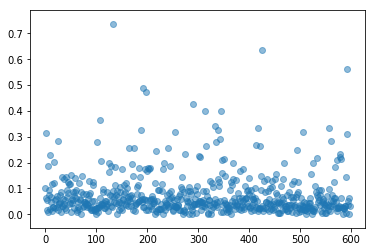

In [305]:
x = range(len(total_rewards))
y = total_rewards
plt.scatter(x, y, alpha=0.5)
plt.show()